<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Project Title: Arabic Sentiment Reviews</p></b></h1>

### Tabel of Contents:

* [Import Libraries](#1)
* [Load Dataset](#2)
* [Bert Model](#4)
* [Evaluation](#3)
* [Like this? Upvote and comment! 🌊 End](#6)

**<a id="1"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Import Libraries</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
!pip install --upgrade transformers wandb

In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import numpy as np
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification,DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
import transformers
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
import wandb
wandb.init(mode="disabled")
import warnings
warnings.filterwarnings('ignore')

**<a id="2"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Load Dataset</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [3]:
data = pd.read_csv('/kaggle/input/chatgpt-user-reviews/CHATGPT.csv')
data = data.rename(columns={"Review": "text"})
data.head()

,text,label
0,up to this point i ’ ve mostly been using chat...,NEGATIVE
1,i ’ ve been a user since it ’ s initial roll o...,NEGATIVE
2,this app would almost be perfect if it wasn ’ ...,NEGATIVE
3,"i recently downloaded the app and overall, it'...",POSITIVE
4,i appreciate the devs implementing siri suppor...,NEGATIVE


In [4]:
data.isna().sum()

text     43
label     0
dtype: int64

In [5]:
data.dropna(inplace=True)

In [6]:
encoder = LabelEncoder()
data.label = encoder.fit_transform(data.label)
data.head()

,text,label
0,up to this point i ’ ve mostly been using chat...,0
1,i ’ ve been a user since it ’ s initial roll o...,0
2,this app would almost be perfect if it wasn ’ ...,0
3,"i recently downloaded the app and overall, it'...",1
4,i appreciate the devs implementing siri suppor...,0


In [7]:
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 2249
})

**<a id="4"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Bert Model</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [8]:
model_name = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2249 [00:00<?, ? examples/s]

In [10]:
dataset_size = len(encoded_dataset)
train_size = int(0.90 * dataset_size)  # 30% for training
valid_size = int(0.05 * dataset_size)  # 1% for validation
test_size = int(0.05 * dataset_size)   # 1% for testing

shuffled_dataset = encoded_dataset.shuffle(seed=42)

# Select 30% for training
train_dataset = shuffled_dataset.select(range(train_size))

# Select 1% for validation (next segment after training set)
valid_dataset = shuffled_dataset.select(range(train_size, train_size + valid_size))

# Select 1% for testing (remaining segment)
test_dataset = shuffled_dataset.select(range(train_size + valid_size, train_size + valid_size + test_size))

In [11]:
test_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 112
})

In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = torch.argmax(torch.tensor(predictions), dim=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}
training_args = TrainingArguments(
    output_dir="./HATGPT_USER_REVIEWS_Bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)


In [13]:
trainer.train()
trainer.save_model()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.353640,0.848214
2,0.349300,0.501483,0.857143
3,0.349300,0.637874,0.883929
4,0.068800,0.767622,0.875000
5,0.068800,0.746514,0.883929


**<a id="1"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Evaluation</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [14]:
results = trainer.evaluate(test_dataset)
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 0.5218798518180847, 'eval_accuracy': 0.9017857142857143, 'eval_runtime': 1.8406, 'eval_samples_per_second': 60.848, 'eval_steps_per_second': 7.606, 'epoch': 5.0}


In [15]:
y_pred_prob = trainer.predict(test_dataset).predictions
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = np.array(test_dataset['label'])

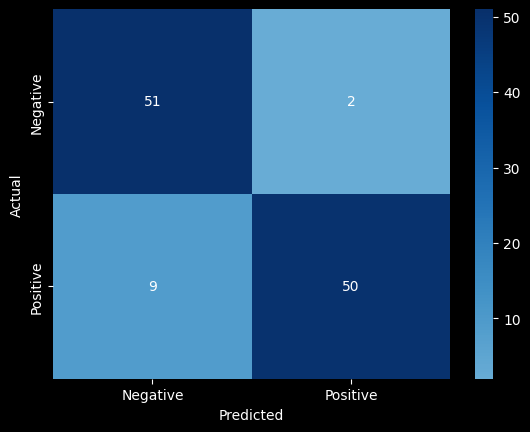

array([[51,  2],
       [ 9, 50]])

In [16]:
CM = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Positive']
plt.style.use('dark_background')
sns.heatmap(CM, annot=True, center=True, fmt='g', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
CM

In [17]:
ClassificationReport = classification_report(y_test, y_pred, target_names=labels)
print('Classification Report is : ', ClassificationReport) 

Classification Report is :                precision    recall  f1-score   support

    Negative       0.85      0.96      0.90        53
    Positive       0.96      0.85      0.90        59

    accuracy                           0.90       112
   macro avg       0.91      0.90      0.90       112
weighted avg       0.91      0.90      0.90       112



**<a id="6"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Like this? Upvote and comment! 🌊 End</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>